In [1]:
from pprint import pprint as pp
from typing import Dict, List, Tuple

import random
import csv

# Building Knowledge Graph

## Extract Data from CSV

In [2]:
def get_csv_data(filepath, handle_row_func):
    data = dict()
    with open(filepath) as file:
        next(file)
        rows = csv.reader(file, delimiter=",")
        for row in rows:
            handle_row_func(data, row)
    return data

In [3]:
def handle_csv_kanji_func(data, row):
    _,kanji,meaning = row
    data[kanji] = meaning

In [4]:
data_kanji = get_csv_data("dataset/s7_nodes_kanji_meaning.csv", handle_csv_kanji_func)
print("len(data_kanji) = ", len(data_kanji))
# pp(data_kanji)

len(data_kanji) =  2136


In [5]:
def handle_csv_radical_func(data, row):
    radical,meaning,_ = row
    data[radical] = meaning

In [6]:
data_radical = get_csv_data("dataset/s7_nodes_radical_meaning.csv", handle_csv_radical_func)
print("len(data_radical) = ", len(data_radical))
# pp(data_radical)

len(data_radical) =  255


In [7]:
def handle_csv_edges_func(data, row):
    kanji,radical_list = row
    data[kanji] = radical_list.split(':')

In [8]:
data_edges = get_csv_data("dataset/s7_edges_kanji_radical.csv", handle_csv_edges_func)
print("len(data_edges) = ", len(data_edges))
# pp(data_edges)

len(data_edges) =  6215


## Data Structure

In [9]:
class KanjiNode:
    def __init__(self, symbol: str, dtype: str, meaning: str):
        self.symbol  = symbol
        self.dtype   = dtype
        self.meaning = meaning        
        self.color = 'red' if dtype == 'kanji' else 'orange'
        
    def __repr__(self):
        return self.symbol + '*' + self.dtype + '*' + self.meaning
    
    def __str__(self):
        return self.symbol + '\n' + self.meaning

In [10]:
class KanjiGraph:
    
    def __init__(self, data_kanji, data_radical, data_edges):
        self.nodes_kanji   = { s: KanjiNode(s, 'kanji', m)   for s, m in data_kanji.items()}
        self.nodes_radical = { s: KanjiNode(s, 'radical', m) for s, m in data_radical.items()}
        
        self.nodes = list(self.nodes_kanji.values()) + list(self.nodes_radical.values())
        
        self.edges = self.convert_into_data_edges(data_edges)
    
    def get_node(self, symbol, dtype):
        if dtype == 'kanji':
            mp = self.nodes_kanji
        elif dtype == 'radical':
            mp = self.nodes_radical
        else:
            raise ValueError(f"{dtype} is not valid")
        if symbol not in mp:
#             raise ValueError(f"{symbol} is not 1 of {len(mp)} nodes_{dtype}")
            return None
        return mp[symbol]
    
    def convert_into_data_edges(self, data_edges):
        kanjigen_edges = []
        
        for kanji, radical_list in data_edges.items():
            kanji_node = self.get_node(kanji, 'kanji')
            if kanji_node != None:
                for r in radical_list:
                    radical_node = self.get_node(r, 'radical')
                    kanjigen_edges.append( (kanji_node, radical_node) )
        return list(set(kanjigen_edges))

In [11]:
kjg = KanjiGraph(data_kanji, data_radical, data_edges)

In [12]:
print(kjg.get_node('人', 'kanji'))

人
person


In [13]:
kjg.nodes[:3]

[亜*kanji*sub-, 哀*kanji*pathetic, 挨*kanji*push open]

In [14]:
kjg.nodes_kanji

{'亜': 亜*kanji*sub-,
 '哀': 哀*kanji*pathetic,
 '挨': 挨*kanji*push open,
 '愛': 愛*kanji*love,
 '曖': 曖*kanji*not clear,
 '悪': 悪*kanji*bad,
 '握': 握*kanji*grip,
 '圧': 圧*kanji*pressure,
 '扱': 扱*kanji*handle,
 '宛': 宛*kanji*allocate,
 '嵐': 嵐*kanji*storm,
 '安': 安*kanji*cheap,
 '案': 案*kanji*plan,
 '暗': 暗*kanji*dark,
 '以': 以*kanji*by means of,
 '衣': 衣*kanji*clothes,
 '位': 位*kanji*rank,
 '囲': 囲*kanji*surround,
 '医': 医*kanji*medicine,
 '依': 依*kanji*reliant,
 '委': 委*kanji*committee,
 '威': 威*kanji*intimidate,
 '為': 為*kanji*do,
 '畏': 畏*kanji*fear,
 '胃': 胃*kanji*stomach,
 '尉': 尉*kanji*military officer,
 '異': 異*kanji*uncommon,
 '移': 移*kanji*shift,
 '萎': 萎*kanji*wither,
 '偉': 偉*kanji*admirable,
 '椅': 椅*kanji*chair,
 '彙': 彙*kanji*same kind,
 '意': 意*kanji*idea,
 '違': 違*kanji*differ,
 '維': 維*kanji*fiber,
 '慰': 慰*kanji*consolation,
 '遺': 遺*kanji*bequeath,
 '緯': 緯*kanji*horizontal,
 '域': 域*kanji*range,
 '育': 育*kanji*nurture,
 '一': 一*kanji*one,
 '壱': 壱*kanji*one (falsification prevention),
 '逸': 逸*kanji*deviate,


In [15]:
kjg.edges[:3]

[(膳*kanji*tray, 丷*radical*eight-head),
 (鳥*kanji*bird, 灬*radical*fire),
 (江*kanji*inlet, 氵*radical*water)]

## Graph

In [16]:
import networkx as nx

In [17]:
G = nx.Graph()

G.add_nodes_from(kjg.nodes)
G.add_edges_from(kjg.edges)

print("nodes:", list(G.nodes())[:5])
print("edges:", list(G.edges())[:2])

nodes: [亜*kanji*sub-, 哀*kanji*pathetic, 挨*kanji*push open, 愛*kanji*love, 曖*kanji*not clear]
edges: [(亜*kanji*sub-, ｜*radical*stick), (亜*kanji*sub-, 口*radical*mouth)]


## Visualization

In [18]:
import matplotlib
import matplotlib.pyplot as plt

### Install Font

In [19]:
import matplotlib.font_manager as fm

# Reference: https://albertauyeung.github.io/2020/03/15/matplotlib-cjk-fonts.html
[f for f in fm.fontManager.ttflist if 'CJK JP' in f.name]

[<Font 'Noto Serif CJK JP' (NotoSerifCJK-Regular.ttc) normal normal 400 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Serif CJK JP' (NotoSerifCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>]

In [20]:
def visualize_graph(Graph: nx.Graph, figsize: tuple=(15,15), color_map: List[str]=None, node_size: int=3000, with_labels: bool=True) -> None:
    if color_map == None:
        color_map = [n.color for n in Graph]  
    else:
        color_map = color_map
    
    plt.figure(1,figsize=figsize) 
    nx.draw_kamada_kawai(Graph, node_color=color_map, with_labels=with_labels, node_size=node_size, font_size=20,font_family="Noto Serif CJK JP")
    plt.show()

### Sample Visualization

In [21]:
def get_sg_kanji_with() -> nx.Graph:
    sg = nx.Graph()
    p = kjg.get_node('痘', 'kanji')
    radical_p = [n for n in G.neighbors(p)]
    sg.add_nodes_from(radical_p + [p])
    sg.add_edges_from([(p, rp) for rp in radical_p])
    return sg

In [22]:
sg = dict() # sample_graph
sg['full_graph'] = G
sg['sample_nodes'] = lambda size: G.subgraph(random.sample(G.nodes, size))
sg['kanji_plus_radical_neighbor'] = get_sg_kanji_with()

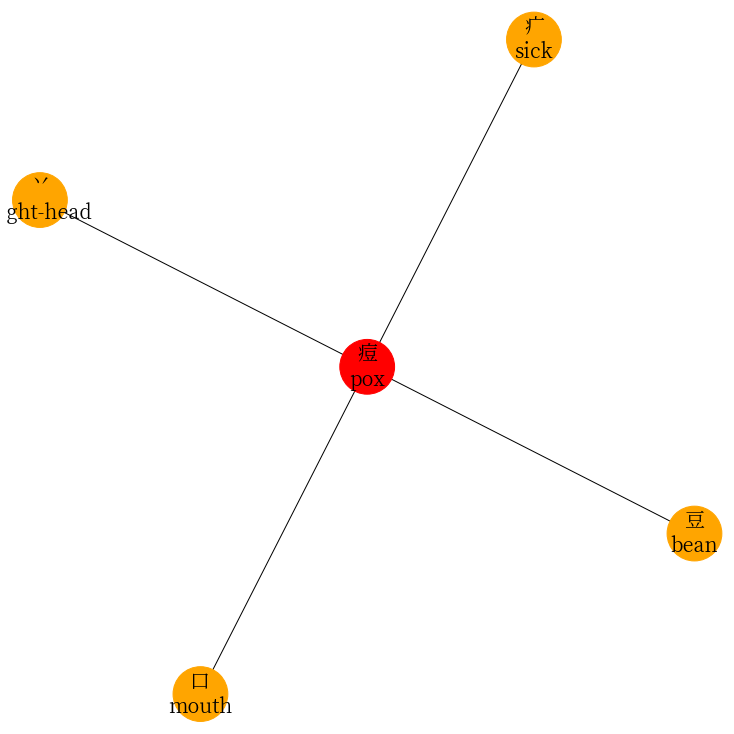

In [23]:
visualize_graph(Graph=sg['kanji_plus_radical_neighbor'], figsize=(10,10))

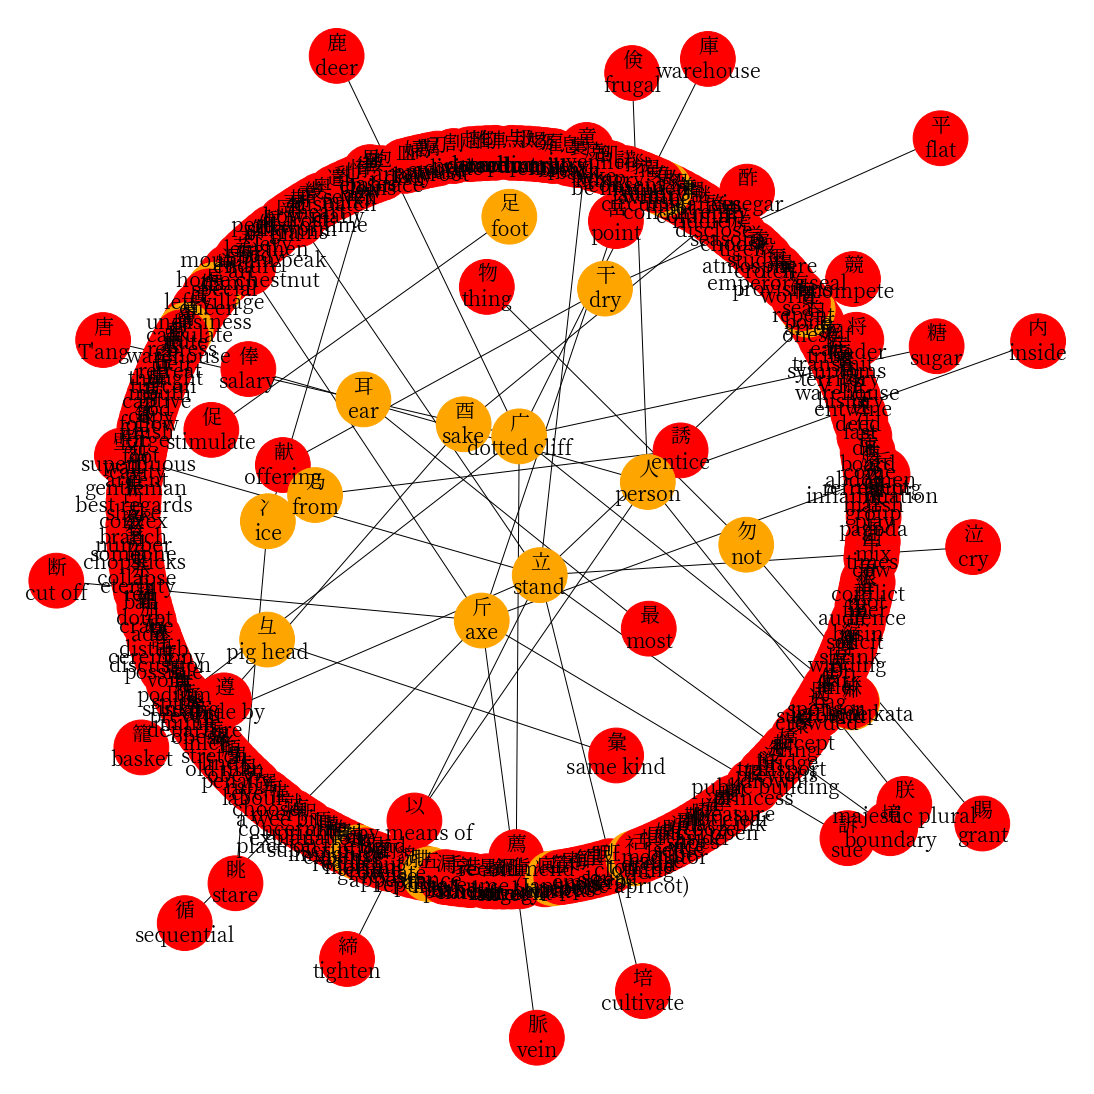

In [24]:
visualize_graph(Graph=sg['sample_nodes'](280), figsize=(15,15))

In [25]:
# visualize_graph(Graph=sg['full_graph'], node_size=1000, with_labels=False)

# Querying Knowledge Graph

## Exploratory Data Analysis

In [26]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2391
Number of edges: 6753
Average degree:   5.6487


In [27]:
# https://networkx.org/documentation/stable/reference/algorithms/component.html

print('number of connected components: ', nx.number_connected_components(G))

number of connected components:  109


In [28]:
# https://networkx.org/documentation/stable/reference/algorithms/isolates.html
# EDA + Preprocessing: Removing Isolated Nodes

print('number of isolated: ', nx.number_of_isolates(G))
isolated_nodes = [k for k in kjg.nodes if k not in nx.isolates(G)]
print(type(isolated_nodes))

# trim kjg node
for k in isolated_nodes:
    if k.dtype == 'kanji':
        kjg.nodes_kanji.pop(k, None)
    elif k.dtype =='radical':
        kjg.nodes_radical.pop(k, None)
kjg.nodes = list(kjg.nodes_kanji.values()) + list(kjg.nodes_radical.values())

G.remove_nodes_from(list(nx.isolates(G)))

number of isolated:  108
<class 'list'>


In [29]:
assert 1 == 0

AssertionError: 

In [30]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2283
Number of edges: 6753
Average degree:   5.9159


In [53]:
node = kjg.get_node('怨', 'kanji')

print(node in G)

True


## User Input

In [54]:
kin = kjg.get_node('人', 'kanji')
kout = kjg.get_node('浦', 'kanji')

result_shortest_path = nx.shortest_path(G, source=kin, target=kout)
print(result_shortest_path)

NodeNotFound: Either source 人
person or target 浦
bay is not in G

In [33]:
def generate_graph(nodes: List[KanjiNode]) -> nx.Graph:
    R = nx.Graph()
    R.add_nodes_from(nodes)
    R.add_edges_from(nx.utils.pairwise(nodes))
    return R

In [34]:
def get_node_color_result(kinputs, koutputs, union_result):
    color_map = []
    for n in union_result:
        if n.symbol in kinputs:
            color_map.append("green")
        elif n.symbol in koutputs:
            color_map.append("blue")
        else:
            color_map.append(n.color)
    return color_map

### Test Case

In [35]:
def get_tc(filepath: str):
    fullpath = f"testcase/{filepath}"
    with open(fullpath) as file:
        return [row.strip() for row in file.readlines()]
    return None

In [36]:
tc_kanji_raw = [(get_tc(f"{i}.in"),get_tc(f"{i}.out")) for i in range(1,11)]

In [37]:
tc_kanji_clean = [{
        'MOrig': [kjg.get_node(o, 'kanji') for o in tc[0] if kjg.get_node(o, 'kanji')],
        'MDest': [kjg.get_node(o, 'kanji') for o in tc[1] if kjg.get_node(o, 'kanji')]
    } for tc in tc_kanji_raw]

In [38]:
pp(tc_kanji_clean[1])

{'MDest': [二*kanji*two,
           丁*kanji*ward,
           行*kanji*go,
           寸*kanji*measurement,
           寺*kanji*Buddhist temple,
           時*kanji*time,
           上*kanji*up,
           刀*kanji*sword,
           分*kanji*part, minute of time,
           私*kanji*me,
           中*kanji*middle,
           事*kanji*abstract thing,
           可*kanji*possible,
           何*kanji*what,
           自*kanji*oneself,
           又*kanji*or again,
           皮*kanji*skin,
           彼*kanji*he,
           方*kanji*direction,
           生*kanji*life,
           月*kanji*month, moon,
           門*kanji*gates,
           間*kanji*interval,
           手*kanji*hand,
           言*kanji*say,
           女*kanji*woman,
           本*kanji*book],
 'MOrig': [人*kanji*person,
           一*kanji*one,
           口*kanji*mouth,
           日*kanji*day,
           目*kanji*eye,
           見*kanji*see,
           山*kanji*mountain,
           出*kanji*exit,
           十*kanji*ten,
           八*kanji*eight,
     

## Brute Force Algorithm

In [40]:
def find_path_bf(MOrig: List[KanjiNode], MDest: List[KanjiNode]) -> nx.Graph:
    
    result = []
    
    for kin in MOrig:
        for kout in MDest:
            sp_raw = nx.shortest_path(G, source=kin, target=kout, method='dijkstra')
            sp_graph = generate_graph(sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

In [41]:
MOrig = tc_kanji_clean[1]['MOrig']
MDest = tc_kanji_clean[1]['MDest']

In [48]:
result = find_path_bf(MOrig, MDest)
result.nodes()

NodeNotFound: Either source 人
person or target 二
two is not in G

In [ ]:
visualize_graph(Graph=result, color_map=get_node_color_result(MO_raw, MD_raw, result))

## All-at-Once

In [ ]:
def find_path_bf(MO: List[KanjigenNode], MD: List[KanjigenNode]) -> nx.Graph:
    
    result = []
    
    for kin in MO:
        for kout in MD:
            sp_raw = nx.shortest_path(G, source=kin, target=kout, method='dijkstra')
            sp_graph = generate_graph(sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)

## Heuristic Algorithm

In [ ]:
def find_path_heuristic(MO: List[KanjigenNode], MD: List[KanjigenNode], dist_func: 'function(o,d)') -> nx.Graph:
    
    result = []
    
    for kin in MO:
        for kout in MD:
            sp_raw = nx.astar_path(G, source=kin, target=kout, heuristic=dist_func)
            sp_graph = generate_graph(sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

In [ ]:
centrality_degree = nx.degree_centrality(G)

In [ ]:
def dist_func(orig: KanjigenNode, dest: KanjigenNode) -> float:
    a = centrality_degree[orig]
    b = centrality_degree[dest]
    return (abs(a-b)) ** 0.5

In [ ]:
result = find_path_heuristic(MO, MD, dist_func)
result.nodes()

## Evaluation

In [ ]:
# https://networkx.org/documentation/stable/reference/algorithms/similarity.html

In [ ]:
# https://networkx.org/documentation/stable/reference/algorithms/centrality.html